# Задача №2 - Пробки в городе

Требуется написать программу, которая на вход принимает картинку, на которой схематически изображена машинка на дороге с полосами и препятствия на полосах. Соответствующие объекты обозначены цветами, которые сохраняются на всех изображениях.

Результатом работы программы является номер полосы, на которую нужно перестроиться или сообщение о том, что перестраиваться не нужно.

Примечание: номер дороги считается слева направо, отсчет начинается с нуля.

In [1]:
# импорт модулей
import cv2
import sys

import matplotlib.pyplot as plt
import numpy as np

## Функция для отрисовки изображения
Используем заранее написанную функцию plot_one_image для отображения картинок.

In [2]:
def plot_one_image(image: np.ndarray, title: str) -> None:
    """
    Отобразить изображение с помощью matplotlib.
    Вспомогательная функция

    :param image: изображение для отображения
    :param title: заголовок для изображения
    :return: None
    """
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))

    plt.title(title)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    plt.show()

## Решение

Загрузим первое изображение и преобразуем его в цветовое пространство HSV, что обычно лучше подходит для выделения цветов.

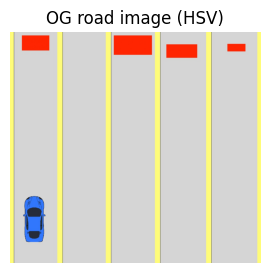

In [3]:
path = r'images//image_00.jpg'

img = cv2.imread(cv2.samples.findFile(path))

if img is None:
    sys.exit("Could not read the image.")

plot_one_image(image=img, title="OG road image (HSV)")

hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

Найдём на загруженном изображении автомобиль (всегда синего цвета) и препятствия на его пути (всегда красного цвета). Для этого создадим маски для автомобиля и препятствий, установив пороги для синего и красного.

In [4]:
red_lower = np.array([0, 100, 100], np.uint8)
red_upper = np.array([10, 255, 255], np.uint8)
obstacle_mask = cv2.inRange(hsv, red_lower, red_upper)

blue_lower = np.array([110, 50, 50], np.uint8)
blue_upper = np.array([130, 255, 255], np.uint8)
car_mask = cv2.inRange(hsv, blue_lower, blue_upper)

Найдём их контуры и отобразим наглядно на отдельном изображении: залитая чёрным картинка с синими и красными контурами машины и препятствий. 

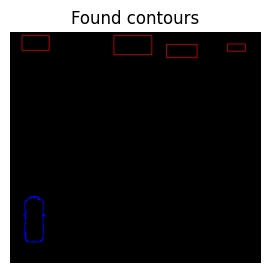

In [5]:
obstacle_contours, _ = cv2.findContours(obstacle_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
found_contours = np.zeros(img.shape, np.uint8)
cv2.drawContours(found_contours, obstacle_contours, -1, (0, 0, 255), 2)

car_contour, _ = cv2.findContours(car_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
cv2.drawContours(found_contours, car_contour, -1, (255, 0, 0), 2)

plot_one_image(image=found_contours, title="Found contours")

Определим количество полос. Известно, что все полосы, кроме одной, перекрыты препятствиями. Поэтому мы можем посчитать количество полос, посчитав количество препятствий и прибавив единицу (чтобы учесть свободную от препятствий дорогу).

Посчитаем также ширину полосы - вычисляется как ширина изображения, делённая на количество полос.

In [6]:
lanes_num = 0
for obstacle in obstacle_contours:
    lanes_num += 1

lanes_num += 1
print(f"Всего полос на картинке: {lanes_num}")

lane_width = img.shape[1] // lanes_num

Всего полос на картинке: 5


Теперь определим полосу автомобиля и наличие препятствий на полосах. 

Ранее мы вычислили ширину полосы. Теперь можем вычислить центр автомобиля, тем самым вычислив, на какой полосе он находится.

Также мы вычисляем, на каких полосах есть препятствие. Сначала мы считаем, что препятствий на полосах нет вовсе, а затем проверяем, как прямоугольники по ширине соотносятся с полосами (чью ширину мы высчитали ранее).

Каждая полоса с препятствием окажется в массиве проверенных полос столько раз, сколько будет циклов.

In [7]:
car_x = int(np.mean([c[0][0] for c in car_contour[0]]))
car_lane = car_x // lane_width

checked_lanes = []
lane_obstacles = [False] * lanes_num
for c in obstacle_contours:
    x, _, w, _ = cv2.boundingRect(c)
    obstacle_lane = x // lane_width
    if (obstacle_lane * lane_width) <= x <= ((obstacle_lane + 1) * lane_width) - w:
        lane_obstacles[obstacle_lane] = True

    for i in range(lanes_num):
        if not lane_obstacles[i]:
            if i != car_lane:
                checked_lanes.append(i)

Последняя проверенная полоса - это и есть искомая, т.е. та, на которой нет препятствий (полосы считаются слева направо, начиная с 0).

In [8]:
if checked_lanes[-1] != car_lane:
    print(f'Нужно перестроиться на полосу номер {checked_lanes[-1]}.')
else:
    print('Перестраиваться не нужно')

Нужно перестроиться на полосу номер 1.


## Найденные полосы для перестройки

Оформим весь вышенаписанный код в виде функции, чтобы применить его к оставшимся картинкам с полосами и препятствиями.

In [9]:
def find_road_number(path_to_image: str):
    """
    Поиск номера полосы, на которую нужно перестроиться

    :param path_to_image: путь к картинке с автомобилем
    :return: строка с результатом
    """

    img = cv2.imread(cv2.samples.findFile(path))

    if img is None:
        sys.exit("Could not read the image.")

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    blue_lower = np.array([110, 50, 50], np.uint8)
    blue_upper = np.array([130, 255, 255], np.uint8)
    car_mask = cv2.inRange(hsv, blue_lower, blue_upper)

    red_lower = np.array([0, 100, 100], np.uint8)
    red_upper = np.array([10, 255, 255], np.uint8)
    obstacle_mask = cv2.inRange(hsv, red_lower, red_upper)

    car_contour, _ = cv2.findContours(car_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    found_contours = np.zeros(img.shape, np.uint8)
    cv2.drawContours(found_contours, car_contour, -1, (255, 0, 0), 2)

    obstacle_contours, _ = cv2.findContours(obstacle_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(found_contours, obstacle_contours, -1, (0, 0, 255), 2)

    lanes_num = 0
    for obstacle in obstacle_contours:
        lanes_num += 1

    lanes_num += 1

    lane_width = img.shape[1] // lanes_num

    car_x = int(np.mean([c[0][0] for c in car_contour[0]]))
    car_lane = car_x // lane_width

    checked_lanes = []
    lane_obstacles = [False] * lanes_num
    for c in obstacle_contours:
        x, _, w, _ = cv2.boundingRect(c)
        obstacle_lane = x // lane_width
        if (obstacle_lane * lane_width) <= x <= ((obstacle_lane + 1) * lane_width) - w:
            lane_obstacles[obstacle_lane] = True

        for i in range(lanes_num):
            if not lane_obstacles[i]:
                if i != car_lane:
                    checked_lanes.append(i)

    if checked_lanes[-1] != car_lane:
        return f'Нужно перестроиться на полосу номер {checked_lanes[-1]}'
    else:
        return 'Перестраиваться не нужно'

Применим написанную функцию к оставшимся двум картинкам. Отобразим сначала саму картинку, зачем - на какую полосу надо перестраиваться.

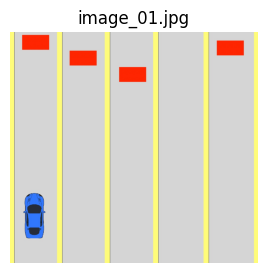

Нужно перестроиться на полосу номер 3


In [10]:
path = r'images//image_01.jpg'

img = cv2.imread(cv2.samples.findFile(path))

if img is None:
    sys.exit("Could not read the image.")

plot_one_image(image=img, title="image_01.jpg")

print(find_road_number(path))

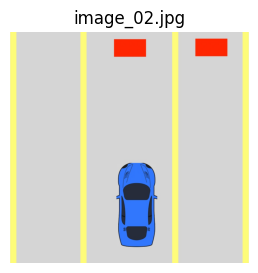

Нужно перестроиться на полосу номер 0


In [11]:
path = r'images//image_02.jpg'

img = cv2.imread(cv2.samples.findFile(path))

if img is None:
    sys.exit("Could not read the image.")

plot_one_image(image=img, title="image_02.jpg")

print(find_road_number(path))